<h1>Churn forecast<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plan" data-toc-modified-id="Plan-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Plan</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#Report" data-toc-modified-id="Report-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Report</a></span></li></ul></div>

The telecommunications operator aims to increase his profit by retaining customers. Since customers do not explicitly express their desire to terminate the services, the goal is to train a model to "predict" potential churners based on their personal data. Therefore, the objective of this project is to forecast customer churn.

## Plan

Data on mobile network customers is provided. The task is to train a machine learning model to predict customer churn based on their personal data, contracts, and services provided. The project plan is divided into several stages:

1. Data preprocessing: changing data types, joining dataframes, handling missing values, adding or removing features, determining the target feature.


2. Exploratory data analysis: examining the distribution of quantitative variables, checking for multicollinearity, identifying outliers, determining the presence of class imbalance.


3. Data preparation for training: dividing the dataset into training and testing sets (using cross-validation), performing one-hot encoding, scaling.


4. Model selection, training, and comparison. For the classification task, random forest and gradient boosting models can be chosen with hyperparameter tuning. If multicollinearity is not high, logistic regression can also be attempted.


5. Model testing and report. It is important to determine the main factor influencing customer churn for the client. The obtained model can provide insights using the feature_importances_ method.

## Preprocessing

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from phik import phik_matrix

In [3]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.svm import SVC
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
try:
    contract = pd.read_csv('contract_new.csv', parse_dates=True)
except:
    contract = pd.read_csv('/datasets/contract_new.csv', parse_dates=True)
    
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4918,6582-PLFUU,2015-11-01,No,Two year,No,Credit card (automatic),19.55,997.05
3831,6946-LMSQS,2017-12-01,No,One year,Yes,Electronic check,89.05,2454.22
5989,5567-WSELE,2019-07-01,2019-09-01,Month-to-month,Yes,Electronic check,94.60,200.55
755,6683-VLCTZ,2018-04-01,2019-02-01,Month-to-month,Yes,Electronic check,98.55,1015.07
1995,8000-REIQB,2019-10-01,No,Month-to-month,Yes,Electronic check,69.95,282.6


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [7]:
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

In [8]:
contract[['BeginDate', 'EndDate']].sample(10)

,BeginDate,EndDate
2807,2019-07-01,NaT
316,2014-03-01,NaT
4749,2019-07-01,NaT
2604,2017-09-01,NaT
5808,2014-02-01,NaT
174,2017-06-01,NaT
3550,2017-04-01,NaT
3350,2019-10-01,NaT
5955,2014-02-01,2016-08-01
6585,2016-07-01,NaT


In [9]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


In [10]:
contract.loc[contract['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,


In [11]:
contract.loc[contract['TotalCharges']==' ', 'TotalCharges'] = contract.loc[contract['TotalCharges']==' ', 'MonthlyCharges']

In [12]:
contract[['MonthlyCharges', 'TotalCharges']].iloc[[488, 753]]

,MonthlyCharges,TotalCharges
488,52.55,52.55
753,20.25,20.25


In [13]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

In [14]:
contract.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2115.377573,2112.678861,19.05,436.75,1343.35,3236.69,9221.38


In [15]:
contract['customerID'].nunique()

7043

In [16]:
contract.isna().sum()

customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
dtype: int64

In [17]:
for _ in ['Type', 'PaperlessBilling', 'PaymentMethod']:
    display(contract[_].value_counts())

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [18]:
try:
    personal = pd.read_csv('personal_new.csv')
except:
    personal = pd.read_csv('/datasets/personal_new.csv')
    
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
3578,4795-WRNVT,Female,0,No,No
4953,1627-AFWVJ,Female,0,No,No
1371,6567-HOOPW,Female,1,No,No
430,9063-ZGTUY,Female,0,Yes,Yes
1826,6908-VVYHM,Male,0,Yes,No


In [19]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [20]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [21]:
personal['customerID'].nunique()

7043

In [22]:
for _ in personal.drop(columns='customerID').columns:
    display(personal[_].value_counts())

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

No     3641
Yes    3402
Name: Partner, dtype: int64

No     4933
Yes    2110
Name: Dependents, dtype: int64

In [23]:
try:
    phone = pd.read_csv('phone_new.csv')
except:
    phone = pd.read_csv('/datasets/phone_new.csv')
    
phone.sample(5)

,customerID,MultipleLines
2577,7610-TVOPG,Yes
3176,4682-BLBUC,No
6184,8217-QYOHV,No
6324,6304-IJFSQ,No
4285,7550-WIQVA,Yes


In [24]:
phone['customerID'].nunique()

6361

In [25]:
len(phone)

6361

In [26]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [27]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

In [28]:
try:
    internet = pd.read_csv('internet_new.csv')
except:
    internet = pd.read_csv('/datasets/internet_new.csv')
    
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4259,0727-IWKVK,Fiber optic,No,Yes,Yes,No,No,No
3116,1200-TUZHR,Fiber optic,No,No,No,No,No,Yes
2292,1428-GTBJJ,Fiber optic,No,Yes,No,No,No,No
3721,8627-EHGIP,DSL,No,Yes,Yes,No,Yes,Yes
4719,9445-SZLCH,Fiber optic,No,Yes,Yes,No,Yes,No


In [29]:
len(internet)

5517

In [30]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [31]:
for _ in internet.drop(columns='customerID').columns:
    display(internet[_].value_counts())

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

No     3473
Yes    2044
Name: TechSupport, dtype: int64

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

In [32]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [33]:
merged = contract.merge(personal, on='customerID', how='outer')
merged = merged.merge(phone, on='customerID', how='outer')
merged = merged.merge(internet, on='customerID', how='outer')

In [34]:
merged.tail()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,2035.20,Male,0,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,Yes,Yes,NaN,DSL,Yes,No,No,No,No,No
7041,8361-LTMKD,2019-07-01,NaT,Month-to-month,Yes,Mailed check,74.40,520.80,Male,1,Yes,No,Yes,Fiber optic,No,No,No,No,No,No
7042,3186-AJIEK,2014-08-01,NaT,Two year,Yes,Bank transfer (automatic),105.65,7251.82,Male,0,No,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


In [35]:
merged.isna().sum()

customerID             0
BeginDate              0
EndDate             5942
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64

In [36]:
data = merged.copy()

In [37]:
data['target'] = np.where(data['EndDate'].notna(), 1, 0)

In [38]:
data.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target
1188,0080-OROZO,2017-03-01,NaT,One year,Yes,Electronic check,99.25,3473.75,Female,0,...,No,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,0
5574,5546-BYZSM,2016-09-01,NaT,Month-to-month,No,Electronic check,20.45,838.45,Female,0,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
247,9947-OTFQU,2018-10-01,2019-07-01,Month-to-month,Yes,Electronic check,74.40,669.60,Male,1,...,No,No,Fiber optic,No,Yes,No,No,No,No,1
3513,4063-EIKNQ,2019-03-01,NaT,Month-to-month,No,Bank transfer (automatic),20.95,232.75,Male,0,...,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
32,6827-IEAUQ,2017-11-01,NaT,One year,No,Mailed check,66.15,1928.93,Female,0,...,Yes,No,DSL,Yes,Yes,Yes,Yes,No,No,0


In [39]:
data['EndDate'].fillna('2020-02-01', inplace=True)
data['EndDate'] = pd.to_datetime(data['EndDate'])
data['usage_period'] = (data['EndDate'] - data['BeginDate']).dt.days
data.drop(columns=['EndDate', 'BeginDate'], inplace=True)
data['usage_period'].sample(10)

5484    2102
3587     396
3359     641
1865    1461
3363    1737
6812    1371
4259     184
5018    1124
6862     184
4515     457
Name: usage_period, dtype: int64

In [40]:
data.drop(columns='customerID', inplace=True)

In [41]:
data.tail()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,usage_period
7038,One year,Yes,Mailed check,84.80,2035.20,Male,0,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,0,730
7039,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0,2191
7040,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,Yes,Yes,NaN,DSL,Yes,No,No,No,No,No,0,337
7041,Month-to-month,Yes,Mailed check,74.40,520.80,Male,1,Yes,No,Yes,Fiber optic,No,No,No,No,No,No,0,215
7042,Two year,Yes,Bank transfer (automatic),105.65,7251.82,Male,0,No,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,0,2010


In [42]:
for _ in internet.drop(columns='customerID').columns.to_list() + ['MultipleLines']:
    data[_].where(data[_].notna(), 'No', inplace=True)

In [43]:
data.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
target              0
usage_period        0
dtype: int64

In [44]:
data.sample(10)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,usage_period
3674,Month-to-month,No,Electronic check,45.80,95.26,Female,0,No,No,No,DSL,No,No,No,No,No,No,0,62
813,One year,No,Bank transfer (automatic),30.40,1033.60,Male,0,Yes,Yes,No,DSL,Yes,No,No,No,No,No,0,1036
5604,Month-to-month,Yes,Electronic check,70.80,1203.60,Male,0,No,No,No,Fiber optic,No,No,No,No,No,No,0,518
1566,Two year,Yes,Bank transfer (automatic),75.40,5700.24,Male,0,Yes,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,0,2191
1738,One year,Yes,Bank transfer (automatic),90.55,6275.12,Female,0,Yes,No,Yes,Fiber optic,No,Yes,Yes,Yes,No,No,0,2010
2416,One year,Yes,Bank transfer (automatic),100.50,2010.00,Male,0,No,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,1,607
5601,One year,No,Mailed check,40.90,1431.50,Female,0,Yes,Yes,No,DSL,No,No,No,Yes,Yes,No,0,1067
5239,One year,No,Credit card (automatic),105.75,7191.00,Male,0,Yes,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,0,2071
3224,Month-to-month,Yes,Electronic check,74.65,783.83,Female,0,No,No,Yes,DSL,No,No,No,Yes,Yes,Yes,0,306
1551,Two year,No,Mailed check,25.25,611.05,Male,0,No,No,Yes,No,No,No,No,No,No,No,0,671


The data types in some columns were changed to datetime and float. The tables were merged using the merge(how=outer) method to avoid losing data from clients who did not receive home phone or internet services. Missing nominal variable data was changed to "No" to show that the client did not receive this service

## EDA

There is class imbalance

In [45]:
data['target'].value_counts()

0    5942
1    1101
Name: target, dtype: int64

The distributions of MonthlyCharges and TotalCharges do not look normal. Later, for MonthlyCharges and TotalCharges columns, we can use MinMaxScaler, but not StandardScaler

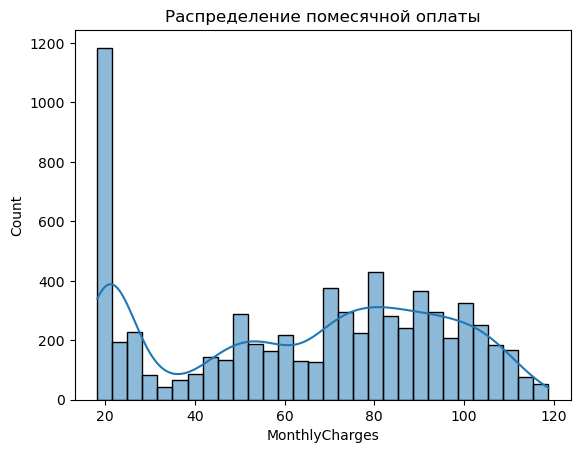

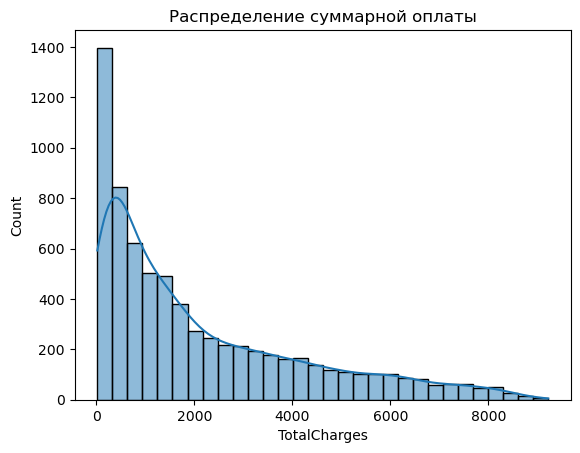

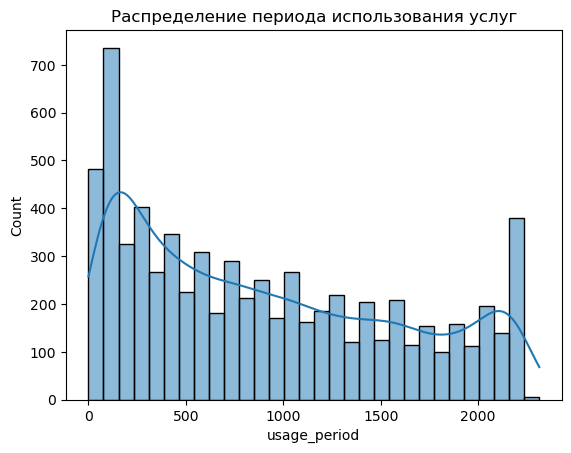

In [46]:
plt.title('Distribution of monthly charges')
sns.histplot(data['MonthlyCharges'], kde=True, bins=30)
plt.show()
plt.title('Distribution of total charges')
sns.histplot(data['TotalCharges'], kde=True, bins=30)
plt.show()
plt.title('DIstribution of usage period')
sns.histplot(data['usage_period'], kde=True, bins=30)
plt.show()

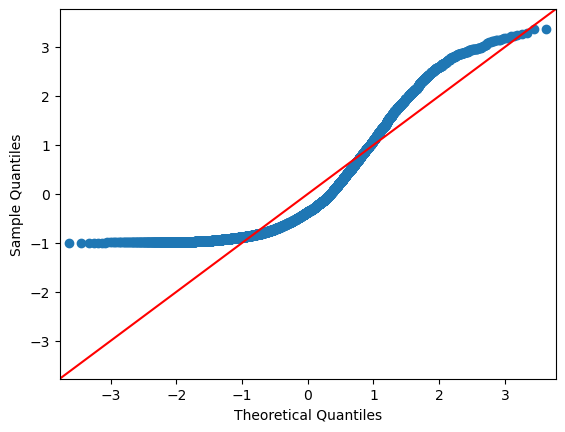

In [47]:
sm.qqplot(data['TotalCharges'], line='45', fit=True)
plt.title('QQ-plot for total charges')
plt.show()

"Suspiciously large" total payments are only 2.8% of the data. It is likely that some consumers are simply paying higher monthly payments or are long-time loyal customers, i.e. there are no outliers

In [48]:
data['TotalCharges'].describe()

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

In [49]:
iqr = data['TotalCharges'].quantile(0.75) - data['TotalCharges'].quantile(0.25)
threshold = data['TotalCharges'].quantile(0.75) + 1.5*iqr
data.loc[data['TotalCharges']>threshold, 'TotalCharges'].count() / len(data)

0.027687065171091863

There is a moderate correlation between monthly and total charges

In [50]:
data['TotalCharges'].corr(data['MonthlyCharges'])

0.6304481289922942

The correlation table below shows that the target variable does not correlate strongly with any other variable. The same is true for the gender of the client. If a client shares services with his partner, the period of service increases. Interestingly, the monthly fees are highly dependent on the use of the internet and paperless billing services

<AxesSubplot:>

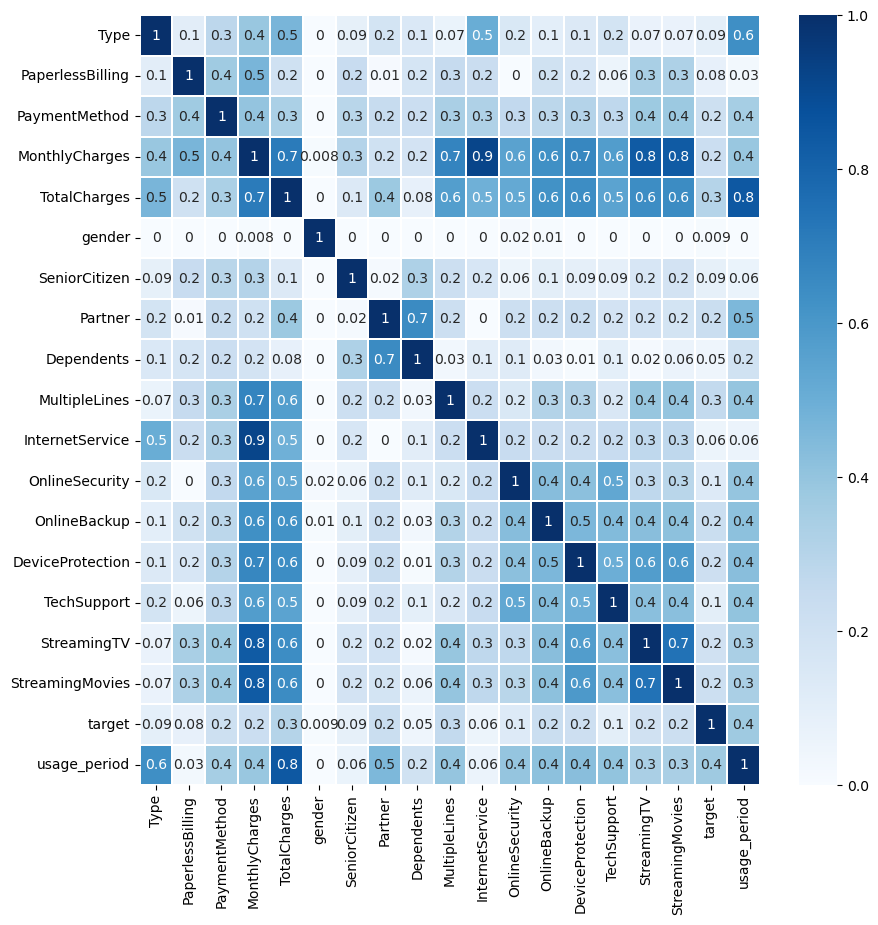

In [51]:
corr_matrix = data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'usage_period'])
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, fmt='.1g', linewidth=0.1, cmap='Blues');

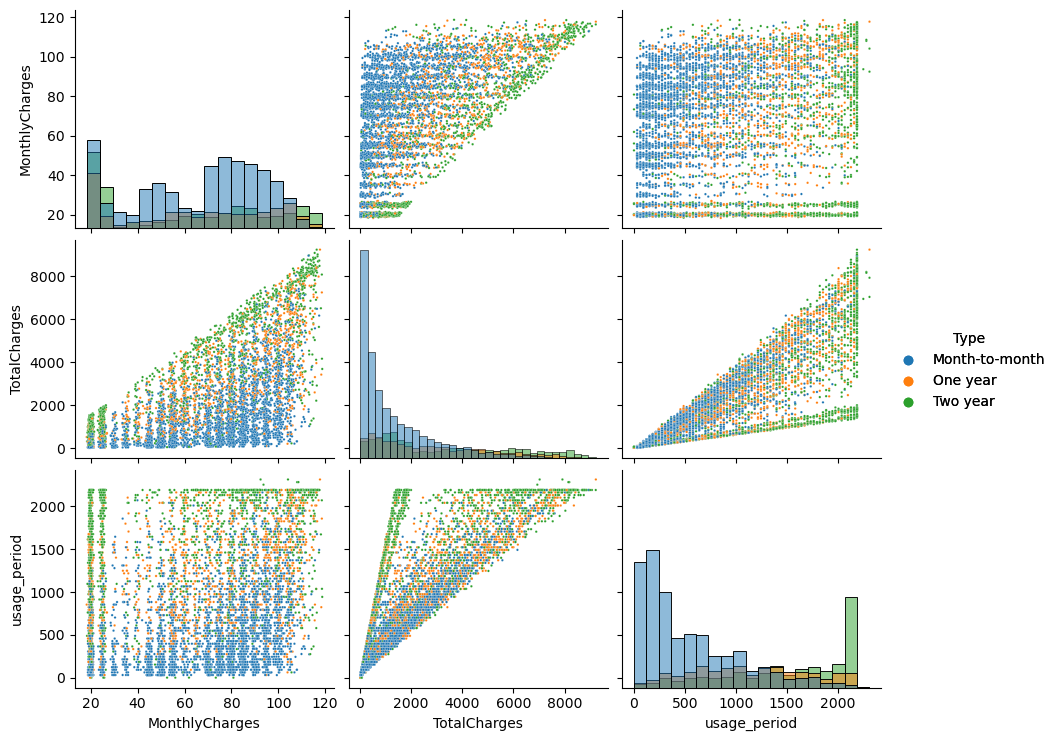

In [52]:
pg = sns.pairplot(data, 
                  hue="Type", 
                  vars=['MonthlyCharges', 'TotalCharges', 'usage_period'],
                  diag_kind='hist',
                  plot_kws={"s": 3})
pg.add_legend();

In [53]:
data.pivot_table(index='target', values=['MonthlyCharges', 'TotalCharges', 'usage_period'], aggfunc={'mean', 'median'})

MonthlyCharges        TotalCharges          usage_period       
                 mean median         mean   median         mean median
target                                                                
0           62.763455   69.2  2067.943095  1192.80   893.681084  702.0
1           75.546004   84.2  2371.377275  2139.03   924.863760  915.0

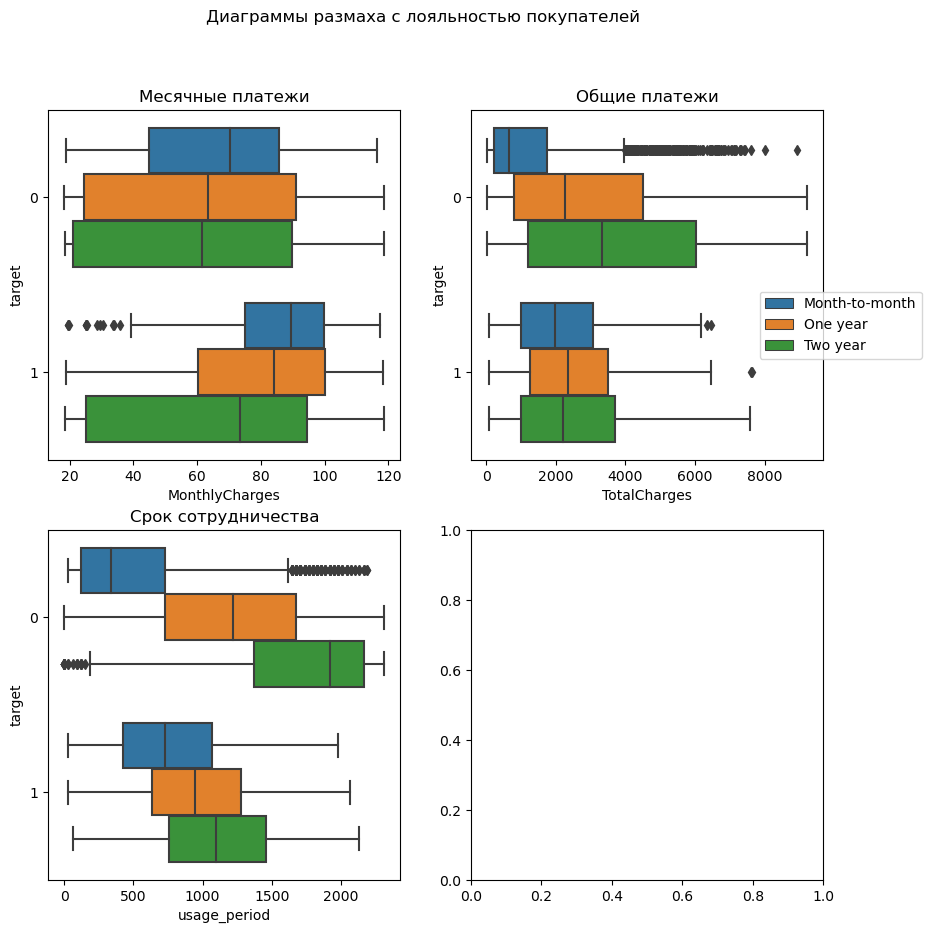

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Boxplots by loyalty')

sns.boxplot(data, x='MonthlyCharges', y=data['target'].astype('str'), ax=axes[0, 0], hue='Type')
axes[0, 0].set_title('Monthly charges')
axes[0, 0].legend([],[], frameon=False)

sns.boxplot(data, x='TotalCharges', y=data['target'].astype('str'), ax=axes[0, 1], hue='Type')
axes[0, 1].set_title('Total charges')
axes[0, 1].legend(bbox_to_anchor=(0.8,0.5))

sns.boxplot(data, x='usage_period', y=data['target'].astype('str'), ax=axes[1, 0], hue='Type')
axes[1, 0].set_title('Usage period')
axes[1, 0].legend([],[], frameon=False);

Text(0.5, 1.0, 'Срок сотрудничества')

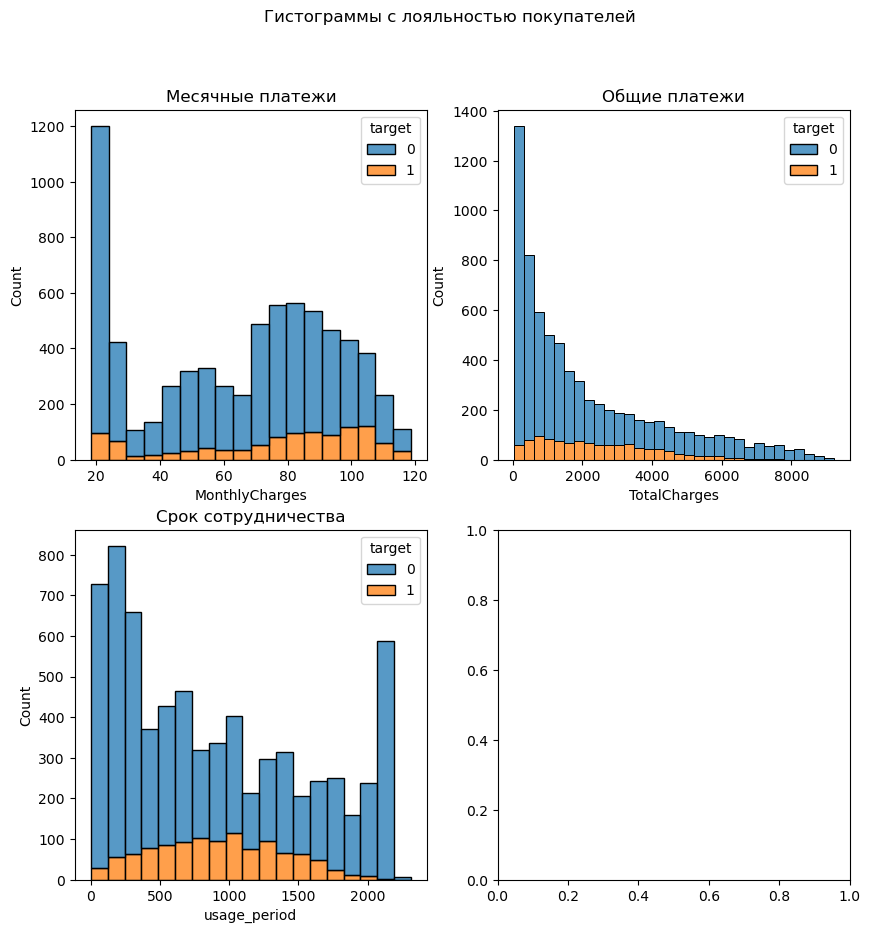

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Histogram by loyalty')
sns.histplot(data, x='MonthlyCharges', hue='target', multiple='stack', ax=axes[0, 0])
axes[0, 0].set_title('Monthly charges')
sns.histplot(data, x='TotalCharges', hue='target', multiple='stack', ax=axes[0, 1])
axes[0, 1].set_title('Total charges')
sns.histplot(data, x='usage_period', hue='target', multiple='stack', ax=axes[1, 0])
axes[1, 0].set_title('Usage period');

There is imbalance of the target variable, quantitative variables are not normally distributed. Customer's gender has almost no effect on consumer behavior. The presence of Internet services in the package is strongly correlated with monthly payments, but not with total payments. Dissatisfied customers, on average, paid more than others, their median total payment is almost 2 times the median total payment of loyal customers

## Data preparation

In [56]:
RANDOM_STATE = 310723

In [57]:
X = data.drop(columns='target')
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

In [58]:
ohe_features = X_train.drop(columns=['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'usage_period']).columns.to_list()
display(ohe_features)
num_features = ['MonthlyCharges', 'TotalCharges', 'usage_period']
num_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

['MonthlyCharges', 'TotalCharges', 'usage_period']

In [59]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features
    ),
    (
        MinMaxScaler(), 
        num_features
    ),
    remainder='passthrough'
)

The data will be pipelined, so there will be no manual coding and scaling required

## Model training

In [60]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)

pipline_lr = make_pipeline(col_transformer, model_lr)

In [61]:
param_grid_lr = {
    'logisticregression__solver': ('liblinear', 'saga'),
    'logisticregression__penalty': ('l1', 'l2'),
    'logisticregression__C': (1, 10, 30),
    'logisticregression__class_weight': ('balanced', None),
    'logisticregression__max_iter': range(400, 1001, 200)
}

gs_lr = GridSearchCV(
    pipline_lr, 
    param_grid=param_grid_lr, 
    scoring='roc_auc', 
    n_jobs=-1,
    cv=5
)

gs_lr.fit(X_train, y_train)

gs_lr_best_score = gs_lr.best_score_
gs_lr_best_params = gs_lr.best_params_
print(f'best_score: {gs_lr_best_score}')
print(f'best_params: {gs_lr_best_params}')

best_score: 0.7791623958259081
best_params: {'logisticregression__C': 10, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 400, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


In [62]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer, model_rf)

In [63]:
param_grid_rf = {
    'randomforestclassifier__n_estimators': range(90, 121, 5),
    'randomforestclassifier__max_depth': range(7, 12),
    'randomforestclassifier__min_samples_split': np.linspace(0.005, 0.01, 200, endpoint=True),
    'randomforestclassifier__min_samples_leaf': np.linspace(0.001, 0.005, 200, endpoint=True),
    'randomforestclassifier__class_weight': ('balanced', 'balanced_subsample', None),
    'randomforestclassifier__max_features': range(10, 20)
}

gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_grid_rf, 
    scoring='roc_auc', 
    n_jobs=-1,
    n_iter = 20,
    cv=5,
    random_state=RANDOM_STATE
)

gs_rf.fit(X_train, y_train)

gs_rf_best_score = gs_rf.best_score_
gs_rf_best_params = gs_rf.best_params_
print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

best_score: 0.8325921969071166
best_params: {'randomforestclassifier__n_estimators': 90, 'randomforestclassifier__min_samples_split': 0.008040201005025126, 'randomforestclassifier__min_samples_leaf': 0.0018241206030150754, 'randomforestclassifier__max_features': 13, 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__class_weight': None}


In [64]:
model_sv = SVC(random_state=RANDOM_STATE)

pipline_sv = make_pipeline(col_transformer, model_sv)

In [65]:
param_grid_sv = {
    'svc__C': (10, 100),
    'svc__gamma': (0.1, 0.01),
    'svc__kernel': ('poly', 'rbf'),
    'svc__class_weight': ('balanced', None),
}

gs_sv = GridSearchCV(
    pipline_sv, 
    param_grid=param_grid_sv, 
    scoring='roc_auc', 
    n_jobs=-1,
    cv=5)

gs_sv.fit(X_train, y_train)

gs_sv_best_score = gs_sv.best_score_
gs_sv_best_params = gs_sv.best_params_
print(f'best_score: {gs_sv_best_score}')
print(f'best_params: {gs_sv_best_params}')

best_score: 0.8161245051673731
best_params: {'svc__C': 100, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [66]:
model_gb = LGBMClassifier(random_state=RANDOM_STATE, 
                          metric='auc', 
                          n_jobs=-1, 
                          is_unbalance=True, 
                          objective='binary')

pipeline_gb = make_pipeline(col_transformer, model_gb)

In [67]:
param_grid_gb = {'lgbmclassifier__boosting_type': ('gbdt', 'dart'),
                 'lgbmclassifier__max_depth': (2, 5),
                 'lgbmclassifier__num_leaves': (8, 16),
                 'lgbmclassifier__learning_rate': (0.1, 0.12, 0.15),
                 'lgbmclassifier__n_estimators': range(500, 1001, 100)
                }

gs_gb = GridSearchCV(
    estimator=pipeline_gb, 
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=5)

gs_gb.fit(X_train, y_train)

gs_gb_best_score = gs_gb.best_score_
gs_gb_best_params = gs_gb.best_params_
print(f'best_score: {gs_gb_best_score}')
print(f'best_params: {gs_gb_best_params}')

best_score: 0.9001375755990738
best_params: {'lgbmclassifier__boosting_type': 'gbdt', 'lgbmclassifier__learning_rate': 0.15, 'lgbmclassifier__max_depth': 2, 'lgbmclassifier__n_estimators': 1000, 'lgbmclassifier__num_leaves': 8}


The best performing model was LGBMClassifier with boosting type gbdt, learning_rate=0.15, maximum depth 2, number of estimators 1000 and number of "branches" 8. Its roc_auc metric on crossvalidation with 5 folds is 0.900

## Testing

In [68]:
best_model = gs_gb.best_estimator_
best_model.fit(X_train, y_train)
predictions = best_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, predictions)
print('roc_auc_score:', auc)

roc_auc_score: 0.9037672825156002


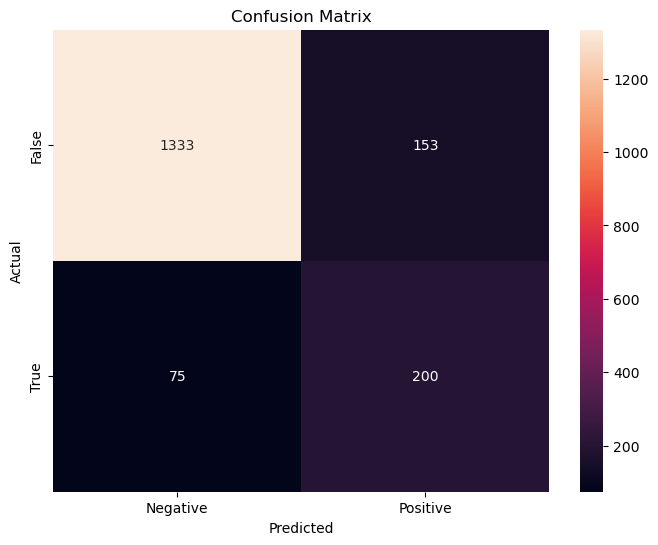

In [69]:
plt.figure(figsize=(8,6))
predicted = best_model.predict(X_test)
ax = sns.heatmap(confusion_matrix(y_test, predicted), annot=True, fmt='d')

ax.set_xlabel("Predicted")
ax.xaxis.set_ticklabels(['Negative', 'Positive'])

ax.set_ylabel("Actual")
ax.yaxis.set_ticklabels(['False', 'True'])

ax.set_title("Confusion Matrix")
plt.show()

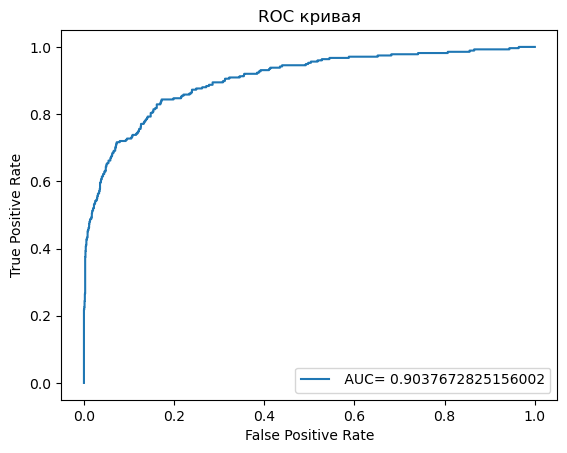

In [70]:
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.plot(fpr, tpr, label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC')
plt.show() 

In [71]:
importances = gs_gb.best_estimator_.named_steps.lgbmclassifier.feature_importances_
columns = gs_gb.best_estimator_[:-1].get_feature_names_out()
pd.DataFrame(importances, index=columns).sort_values(by=0, ascending=False)

,0
minmaxscaler__usage_period,1387
minmaxscaler__TotalCharges,578
minmaxscaler__MonthlyCharges,536
onehotencoder__Type_Two year,61
onehotencoder__Partner_Yes,50
onehotencoder__Type_One year,47
onehotencoder__Dependents_Yes,42
onehotencoder__PaymentMethod_Credit card (automatic),41
onehotencoder__TechSupport_Yes,26
onehotencoder__PaymentMethod_Mailed check,25


In [94]:
columns

array(['onehotencoder__Type_One year', 'onehotencoder__Type_Two year',
       'onehotencoder__PaperlessBilling_Yes',
       'onehotencoder__PaymentMethod_Credit card (automatic)',
       'onehotencoder__PaymentMethod_Electronic check',
       'onehotencoder__PaymentMethod_Mailed check',
       'onehotencoder__gender_Male', 'onehotencoder__Partner_Yes',
       'onehotencoder__Dependents_Yes',
       'onehotencoder__MultipleLines_Yes',
       'onehotencoder__InternetService_Fiber optic',
       'onehotencoder__InternetService_No',
       'onehotencoder__OnlineSecurity_Yes',
       'onehotencoder__OnlineBackup_Yes',
       'onehotencoder__DeviceProtection_Yes',
       'onehotencoder__TechSupport_Yes', 'onehotencoder__StreamingTV_Yes',
       'onehotencoder__StreamingMovies_Yes',
       'minmaxscaler__MonthlyCharges', 'minmaxscaler__TotalCharges',
       'minmaxscaler__usage_period', 'remainder__SeniorCitizen'],
      dtype=object)

In [95]:
col = ['Contract: 1 year', 
       'Contract: 2 years', 
       'Paperless billing', 
       'Payment: credit card', 
       'Payment: electronic check', 
       'Payment: mailed check', 
       'Gender: male', 
       'Partner',
       'Dependents',
       'Multiple lines',
       'Internet: fiber optic',
       'Intenet: None',
       'Online Security',
       'Online backup',
       'Device protection',
       'Tech support',
       'Streaming TV',
       'Streaming movies',
       'Monthly charges',
       'Total charges',
       'Usage period',
       'Senior citizen'
      ]

In [96]:
X_shap = gs_gb.best_estimator_.named_steps.columntransformer.transform(X_test)

In [97]:
explainer = shap.TreeExplainer(gs_gb.best_estimator_.named_steps.lgbmclassifier)
shap_values = explainer.shap_values(X_shap)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


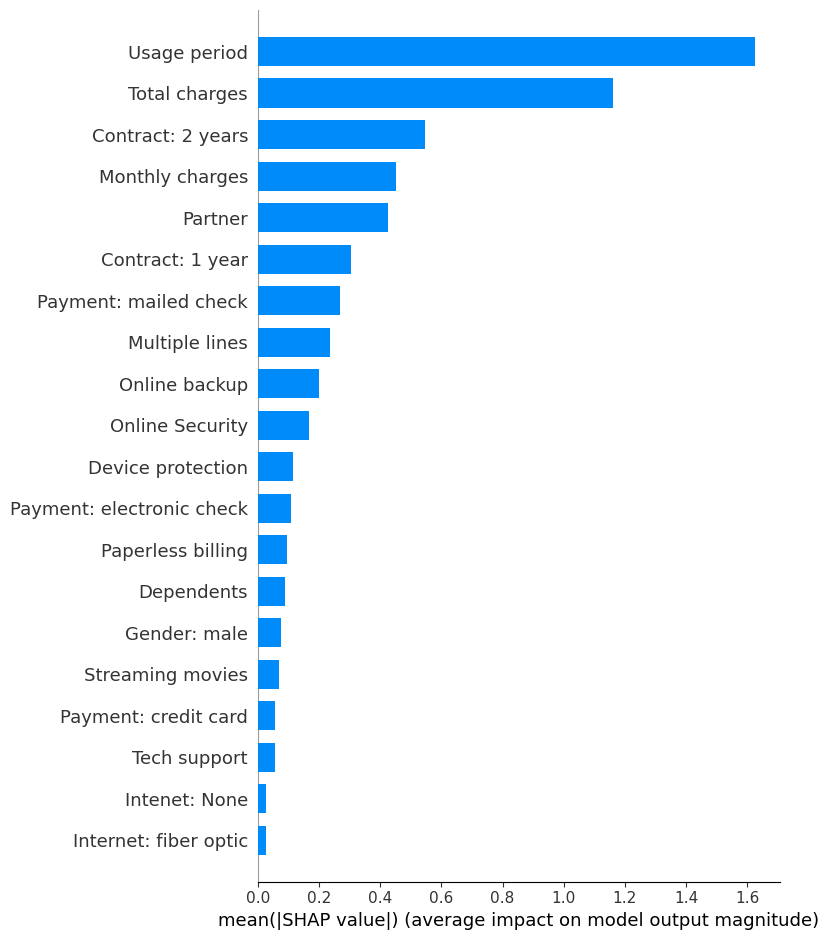

In [98]:
shap.summary_plot(shap_values[1], X_shap, plot_type='bar', 
                  feature_names=col)

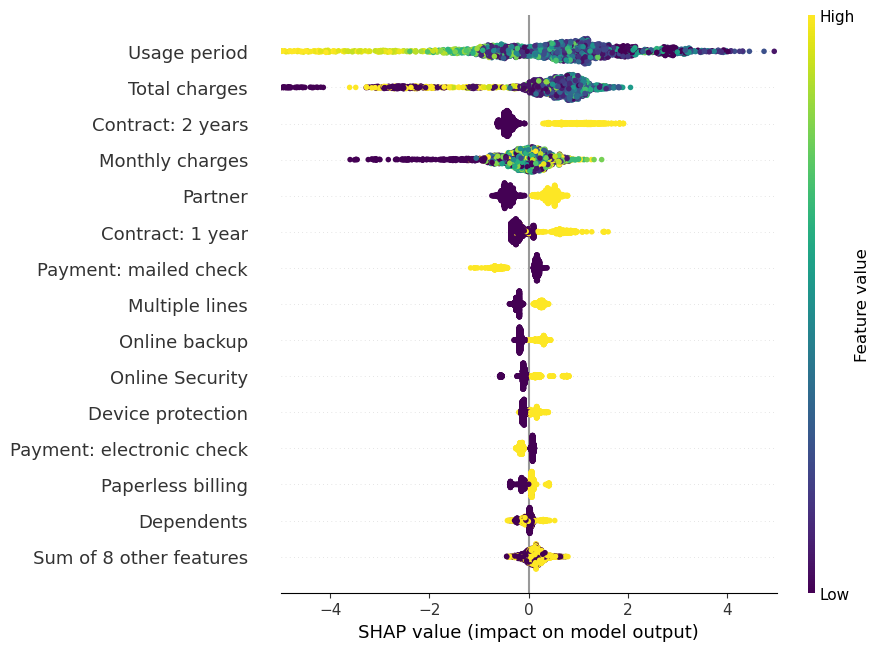

In [99]:
shap_values_X = explainer(X_shap)

explanation = shap.Explanation(
    values=shap_values_X, 
    base_values=shap_values_X.base_values, 
    data=shap_values_X.data, 
    feature_names=col
)
shap.plots.beeswarm(explanation[:, :, 1], show=False, color='viridis', max_display=15)

ax = plt.gca()

ax.set_xlim(-5, 5)
plt.show()

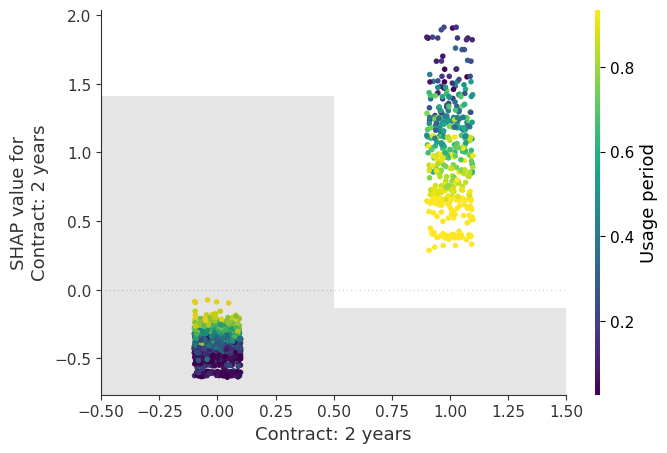

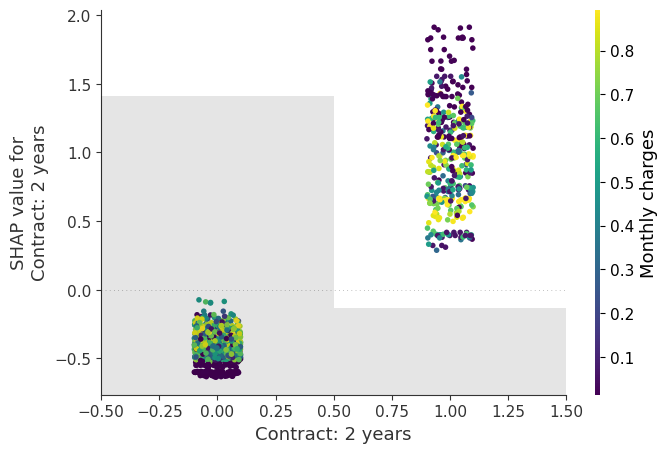

In [103]:
X_scatter = pd.DataFrame(X_shap, columns=col)
shap_scatter = explainer(X_scatter)

shap.plots.scatter(shap_scatter[:, "Contract: 2 years", 1], 
                   color=shap_scatter[:, :, 1], 
                   cmap=plt.get_cmap('viridis'))

shap.plots.scatter(shap_scatter[:, "Contract: 2 years", 1], 
                   color=shap_scatter[:, 'Monthly charges', 1], 
                   cmap=plt.get_cmap('viridis'))

Test conclusions:

- The resulting model yielded an estimate of roc_auc=0.904 on the test sample. The model is not overfitted


- The confusion matrix shows that the model performs well in classification. However, it often incorrectly predicts customer leaving. This can lead to unnecessary spending on discounts and promo codes


- The top five most important attributes for the model were: 
        The duration of the partnership, 
        total payments, 
        the presence of a two-year contract,
        monthly payments,
        presence of a partner


As shap shows,

- Loyal customers remain loyal. In other words, according to the model, the higher the term of cooperation with a client, the lower the probability of him/her leaving


- Two-year contracts increase the probability of a customer leaving. However, there is some variability in shap values among such customers, so their behavior is influenced by other attributes. New clients with two-year contracts tend to leave. Clients with lower monthly payments and a two-year contract tend to leave


- Lower monthly payments generally maintain customer loyalty. However, higher total payments strongly influence the negative prediction of the model. Perhaps this model behavior is influenced by the multicollinearity of total payments and the term of cooperation


- A mailed check has a positive effect on customer retention

## Report

The customer specified _the goal of reducing customer churn_. This required building a machine learning model that would predict the customer's departure based on his personal data and information about the services rendered to him.
The _work plan_ described at the beginning of the project has been fully implemented. The _intermediate tasks_ of preprocessing, exploratory analysis, preparing the data for training, crossvalidating the models, and testing them are equally important and have been accomplished with minor changes from the original plan:

- In the exploratory analysis, in addition to determining imbalance, multicollinearity, and normality of variables, histograms of the distribution of cooperation period, monthly and total payments, distinguishing between loyal and leaving customers, and scatter plots according to contract type were added. The average and median monthly and total payment checks for loyal and leaving clients were derived. The latter paid more for services than the others.


- The original plan was to encode and scale the training sample in its entirety. Then, to prevent overtraining, coding and scaling were added to the pipeline. Thus, data preprocessing was performed on each stratified fold rather than on the whole training set.


- In addition to random forest, gradient boosting and logistic regression, SVC classifier was considered. 


- In the testing phase, the ROC curve plot and heatmap of the confusion matrix were plotted. 


- The importance of features was analyzed using shap.

Preprocessing:

1. "contract_new.csv"

    |Column| Preprocessing|
    |--|--|
    |customerID      | - |
    |BeginDate       | data type was changed to datetime  |
    |EndDate         | data type was changed to datetime  |
    |Type            | - |
    |PaperlessBilling| - |
    |PaymentMethod   | - |
    |MonthlyCharges  | - |
    |TotalCharges    | spaces were changed to corresponding values of MonthlyCharges, data type - to float|
    

2. "personal_new.csv" was left the same
3. "phonne_new.csv"   was not changed
4. "internet_new.csv" was not preprocessed

- The dataframes were merged externally _merge(how='outer')_ on the customerID index. Resulting missing values in categorical variables were changed to 'No'. 

- The target attribute was generated based on EndDate, which contains the customer's leaving date

- The usage_period column was added as the difference of the EndDate and BeginDate columns. For loyal customers it is the difference between '2020-02-01' and the contract signing date. After adding the target, the EndDate and BeginDate columns were removed to avoid target leakage

- The customerID column was removed as unnecessary. As a result, the following attributes remained:

    1. Type
    2. PaperlessBilling
    3. PaymentMethod
    4. MonthlyCharges
    5. TotalCharges
    6. gender
    7. SeniorCitizen
    8. Partner
    9. Dependents
    10. MultipleLines
    11. InternetService
    12. OnlineSecurity
    13. OnlineBackup
    14. DeviceProtection
    15. TechSupport
    16. StreamingTV
    17. StreamingMovies
    18. usage_period
    19. target

After tuning and model selection the following model was chosen:

        LGBMClassifier(is_unbalance=True, learning_rate=0.15, max_depth=2, 
                       metric='auc', n_estimators=1000, num_leaves=8,
                       objective='binary', random_state=310723).

roc_auc_score is equal to 0.900 on crossvalidation, on testing set (0.25 of the whole dataset) - 0.904, that is the model is not overfitted